In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial   
import datetime

In [5]:
ser=serial.Serial("/dev/ttyACM0",115200,timeout=2)
ser.baudrate=115200

In [6]:
def pulse(pon: int=200,poff:int=200,damp:int=2000):
    ser.write(bytearray("start acq "+str(pon)+" "+str(poff)+" "+str(damp)+"\n",'ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    D = ser.readline()
    return D



In [8]:
pulse()

b'run> '

In [9]:
def dac(gain=200):
    ser.write(bytearray("write dac "+str(gain)+"\n",'ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    return B

In [10]:
def read():
    ser.write(bytearray('read\n','ascii'))
    A = ser.readline()
    B = ser.readline()
    C = ser.readline()
    D = ser.readline()
    S = [x.replace("b'","") for x in str(C).split(",") if len(x)]
    print(len(S))
    signal = [(int(x,16)-512)/512.0 for x in S[:-1]]
    return signal

8001


KeyboardInterrupt: 

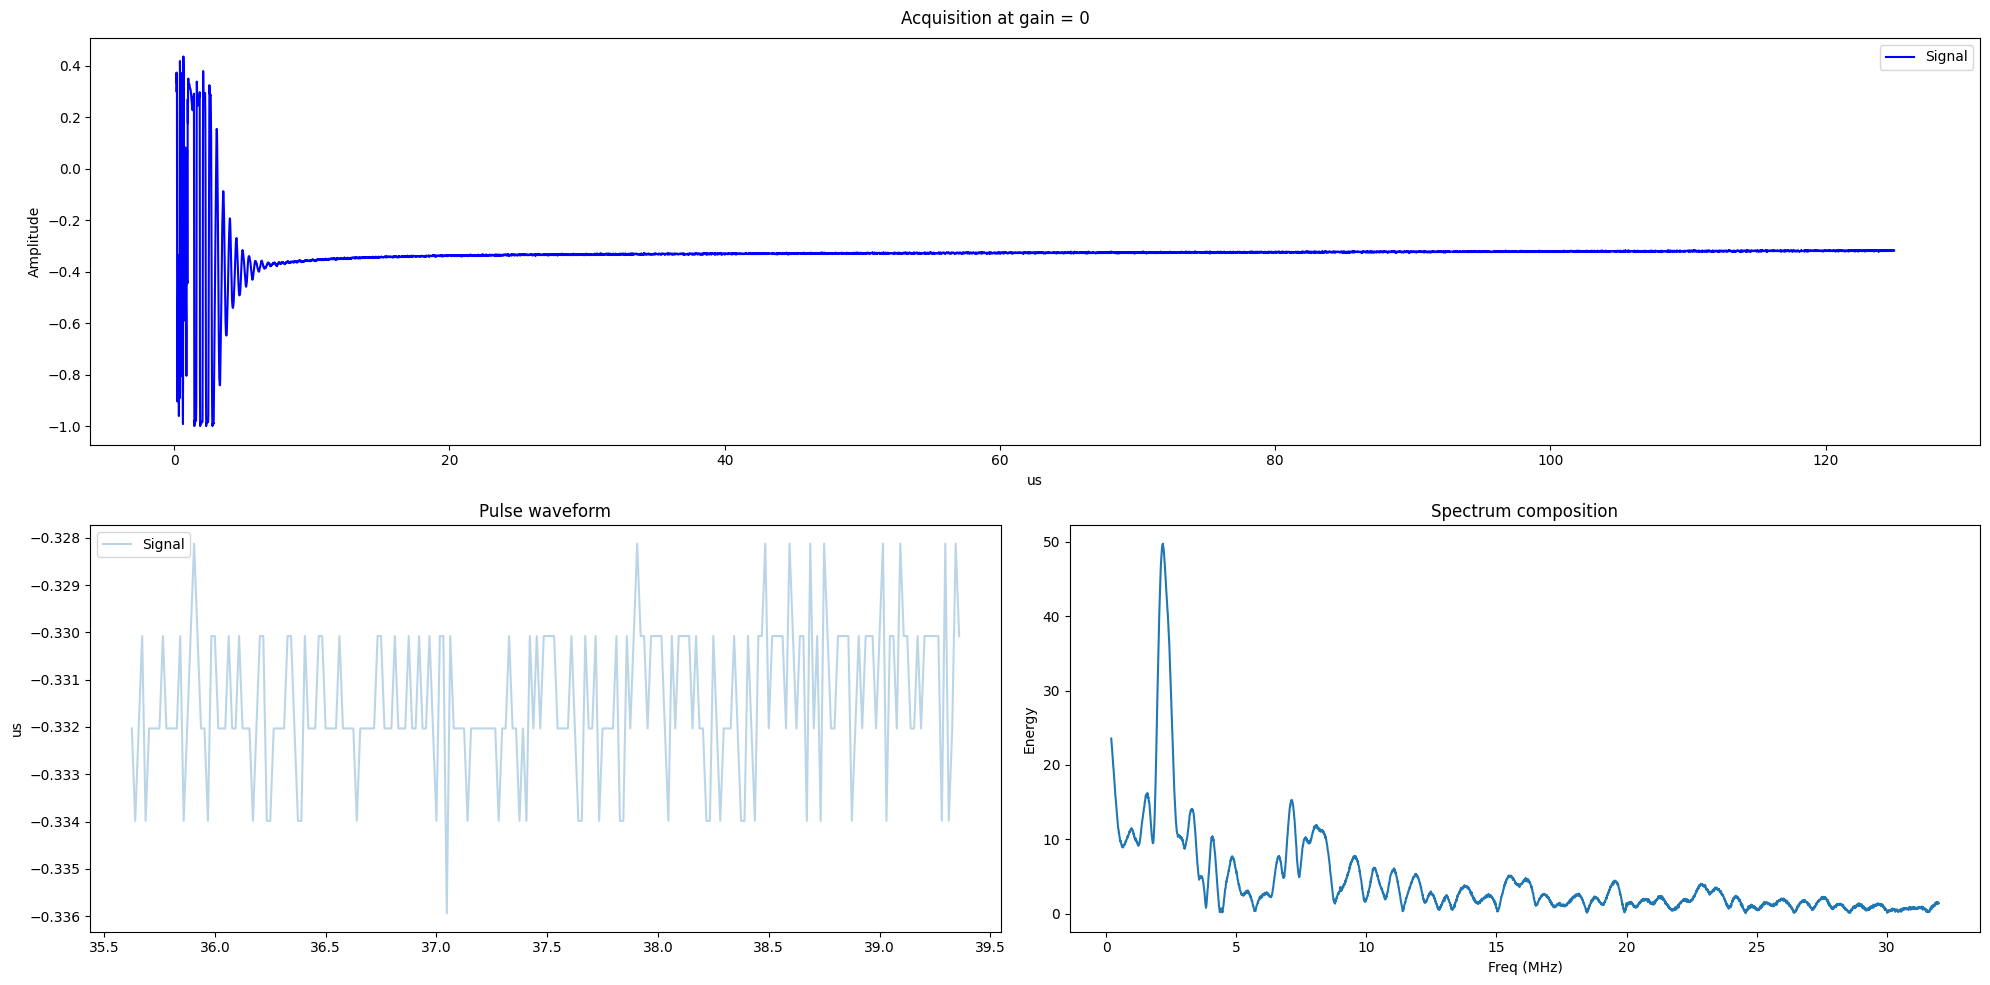

In [11]:
for G in range(10):
    dac(gain=G*100)
    pulse(pon=200,poff=200,damp=8000)
    signal = read()
    dac(gain=0)
    now = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
    t = [x/64.0 for x in range(len(signal))]
    f = [k*64/len(signal) for k in range(len(signal))]

    data = {"signal":signal,"t":t,"f":f,"gain":G,"timestamp":now}

    m=800

    FFT = np.abs(np.fft.fft(signal))

    plt.figure(figsize=(20,10))
    plt.subplot(2, 1, 1)

    plt.plot(t[10:],signal[10:],"b",label="Signal")
    plt.xlabel("us")
    plt.ylabel("Amplitude")
    plt.legend()
    title = "Acquisition at gain = " + str(G)

    plt.subplot(2, 2, 3)
    plt.plot(t[38*60:42*60],signal[38*60:42*60],alpha=0.3,label="Signal")
    plt.title('Pulse waveform')
    plt.ylabel('V')
    plt.ylabel('us')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title('Spectrum composition')
    plt.plot(f[25:len(FFT)//2],FFT[25:len(FFT)//2])
    plt.xlabel('Freq (MHz)')
    plt.ylabel('Energy')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("imgs/rp2350/pic0gain_at_"+str(G)+".jpg")
    np.savez_compressed("imgs/rp2350/pic0gain_at_"+str(G), **data )